### Tumor Classification

- follow https://colab.research.google.com/drive/1CKsJqNFpT8qfedfzqjq_fR7rmUjU6LXa#scrollTo=5I7vllBbzFbA
- same as https://github.com/YaminArefeen/pytorch_tutorial_6.862
- Data from Kaggle [link](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

In [1]:
import torch
import torchvision

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as pyplot
%matplotlib inline

In [5]:
# Downloading the Data
# !wget -O data.zip "https://www.dropbox.com/sh/5x3odwr1azs6fe6/AACJugYtmbOuFr763XUqy8ZWa?dl=1"
# !unzip data.zip

zsh:1: command not found: wget
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


### Create custom dataset Class

In [13]:
#Quick helper function which will reshape all of our images to the same size
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)]

class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_size = (128, 128)):
        # Whenever we initalize a dataset with our "TumorDataset" class, the code in the initialize function 
        # will be called. In this code, we specify the root directory of the current dataset we want to work with, 
        # the list of classes in that root directory (by listing the folder names), and the desired image size
        self.root         = root                      # The root directory of the current training (or validation or testing) dataset that we want to work with
        self.class_names  = os.listdir(self.root)     # Lists the name of folders in our root directory, which in our case, also serves as the class names
        self.image_size   = image_size                # Image size which will be used      
        
    def __len__(self):
        dataset_size = 0   #Variable which we will use to keep track of dataset length
        
        for cur_class in self.class_names:
            #Recall, that each class relates to a folder which contains our images.  In this for loop, we compute the number of entries in each folder (which corresponds to 
            #the number of samples in each class) and then add it to our total running count of the dataset size.  
            dataset_size += len(os.listdir(self.root + cur_class + '/'))
            
        return dataset_size
    
    def __getitem__(self,index):
        if(index >= len(self)):
            print('Index out of bounds')
            return 
          
        cur_dataset_size = 0
        class_label      = 0
        image_index      = index
        
        for cur_class in self.class_names:
            #Loop through each of our classes
            
            cur_path       = self.root + cur_class + '/'
            files_in_class = os.listdir(cur_path)
            #Generate a list of .JPG files which correspond to our samples for this particular class
                                       
            cur_dataset_size += len(files_in_class)
            #We assume that our classes are ordered back to back for indexing.  So let's say (for example), that our first class 'no', 
            #has 10 samples, our second class 'yes' has 10 samples, and 'no' comes before 'yes' in ordering.  Then dataset[9] will index the 
            #10th image in the 'no' class, while dataset[10] will index the first image in the 'yes' class.  (recall, python zero indexes).
            #Thus, by keeping track of how much of the total dataset we've traversed, with cur_dataset_size, we can check to see whether index corresponds
            #to the current class
            
            if(index < cur_dataset_size):
                #If index is less than the current data set size, then we know that index should grab an element from this class        
                
                image_index = index - cur_dataset_size
                #Find which element of this class our index corresponds too
                
                image = np.asarray(Image.open(cur_path + files_in_class[image_index]),dtype=np.double)
                #Grab the image and convert it to a numpy array
                
                if len(image.shape) == 3:
                    image = image[:,:,0]
                #Take just the first channel for gray-scale
                
                image = np.expand_dims(scale(image,self.image_size[0],self.image_size[1]),axis = 0)
                #Reshape the image to size 1 x 128 x 128
                
                return (image,class_label)
                #Return the image and its associated label as a tuple
            
            class_label += 1
    


In [14]:
path_train_set   = 'brain_tumor_dataset/train/'     #Specify the path to the trainining root directory
dataset_train    = TumorDataset(path_train_set)     #Create the dataset class using the path to the root directory for the training data as an input

In [15]:
# quick checks of dataset

print('Specified root directory for our dataset class:')
print(dataset_train.root)
print('')

print('List of class names:' )
print(dataset_train.class_names)
print('')

print('Hard-coded Image Size:' )
print(dataset_train.image_size)
print('')

print("Samples in the dataset: %d" % len(dataset_train))
print("A Sample: {}".format(dataset_train[0]))

Specified root directory for our dataset class:
brain_tumor_dataset/train/

List of class names:
['no', 'yes']

Hard-coded Image Size:
(128, 128)

Samples in the dataset: 222
A Sample: (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), 0)


Tumor Example
 image:


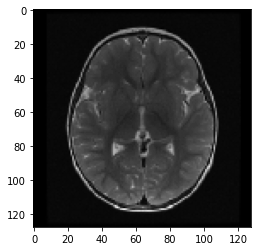

 label: 0
Non-Tumor Example
 image:


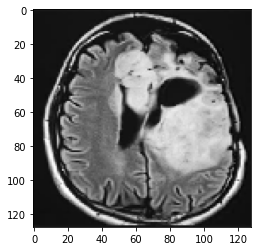

 label: 1


In [16]:
print('Tumor Example')
index = 10
print(' image:')
pyplot.imshow(np.squeeze(dataset_train[index][0]),cmap = 'gray')
pyplot.show()
print(' label: %d' % dataset_train[index][1])

print('Non-Tumor Example')
index = 180
print(' image:')
pyplot.imshow(np.squeeze(dataset_train[index][0]),cmap = 'gray')
pyplot.show()
print(' label: %d' % dataset_train[index][1])

### Incorporating Dataloaders in pytorch

In [17]:
batch_size = 4
#Setting our desired batch size

dataloader_training = torch.utils.data.DataLoader(dataset_train,batch_size = batch_size,shuffle=True)
#Initializing our dataloader for the training dataset.  By setting the shuffle flag to True, 
#the dataloader will loop through the entire dataset randomly

In [18]:
# loop through the dataset with the dataloader
for i_batch, sampled_batch in enumerate(dataloader_training):
    cur_images = sampled_batch[0] #Grab the images from this batch
    cur_labels = sampled_batch[1] #Grab the corresponding labels from this batch

    print('Batch %d' % (i_batch + 1))
    print('Batch Dimensions:    ', end = '')
    print(cur_images.shape)
    print('Batch Labels:        ', end = '')
    print(cur_labels)

# In our dataset class, we didn't manually convert our loaded images to PyTorch tensors nor did we add 
# any functionality to load the data by batches across the entire dataset. Dataloaders handle both these 
# issues for us.

Batch 1
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 0, 0])
Batch 2
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 0, 1])
Batch 3
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 1, 1])
Batch 4
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 1, 1])
Batch 5
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 0, 0])
Batch 6
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 0, 1])
Batch 7
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 1, 1])
Batch 8
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 1, 1])
Batch 9
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 1, 1])
Batch 10
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 0, 1, 1])

### Creating the model

In [19]:
class TumorClassificationModel(torch.nn.Module):
    def __init__(self,kernel_size = 5):
        super().__init__()
        
        self.maxpool    = torch.nn.MaxPool2d(2,2)
            
        self.convlayer1      = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=kernel_size)
        self.convlayer2      = torch.nn.Conv2d(in_channels=6,out_channels=15,kernel_size=kernel_size)
        
        self.flatten = torch.nn.Flatten(start_dim = 1)

        self.fully_connected1 = torch.nn.Linear(15 * 29 * 29, 120)
        self.fully_connected2 = torch.nn.Linear(120,60)
        self.fully_connected3 = torch.nn.Linear(60,1)

    def forward(self, x):

        print('Input shape: {}'.format(x.shape))
        
        x = self.maxpool(torch.nn.functional.relu(self.convlayer1(x)))
        print('After conv + pool 1: {}'.format(x.shape))
        
        x = self.maxpool(torch.nn.functional.relu(self.convlayer2(x)))
        print('After conv + pool 2: {}'.format(x.shape))
        
        x = self.flatten(x)
        print('After reshaping for fully_connected layers: {}'.format(x.shape))
        
        x   = torch.nn.functional.relu(self.fully_connected1(x))
        print('After fully_connected 1: {}'.format(x.shape))
        
        x   = torch.nn.functional.relu(self.fully_connected2(x))
        print('After fully_connected 2: {}'.format(x.shape))
        
        out = torch.sigmoid(self.fully_connected3(x))
        
        return out

In [20]:
# Run once to check dimensions

test_model = TumorClassificationModel().double()
#Initializing our model

dataloader_iterator = iter(dataloader_training)
test_input, _       = next(dataloader_iterator)
#Grabbing a single batch

print('Output Shape: {}'.format(test_model(test_input).shape))

Input shape: torch.Size([4, 1, 128, 128])
After conv + pool 1: torch.Size([4, 6, 62, 62])
After conv + pool 2: torch.Size([4, 15, 29, 29])
After reshaping for fully_connected layers: torch.Size([4, 12615])
After fully_connected 1: torch.Size([4, 120])
After fully_connected 2: torch.Size([4, 60])
Output Shape: torch.Size([4, 1])


In [21]:
# redefine model w/o printing options
# a consice version with fixed dimension

class TumorClassificationModel(torch.nn.Module):
    def __init__(self,kernel_size = 5):
        super().__init__()
        
        self.maxpool    = torch.nn.MaxPool2d(2,2)
            
        self.convlayer1 = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=kernel_size)
        self.convlayer2 = torch.nn.Conv2d(in_channels=6,out_channels=15,kernel_size=kernel_size)
        
        self.fully_connected1 = torch.nn.Linear(15 * 29 * 29, 120)
        self.fully_connected2 = torch.nn.Linear(120,60)
        self.fully_connected3 = torch.nn.Linear(60,1)
        
    def forward(self, x):

        x = self.maxpool(torch.nn.functional.relu(self.convlayer1(x)))
        x = self.maxpool(torch.nn.functional.relu(self.convlayer2(x)))
        
        x   = torch.nn.functional.relu(self.fully_connected1(x.view(-1,15*29*29)))
        x   = torch.nn.functional.relu(self.fully_connected2(x))
        out = torch.sigmoid(self.fully_connected3(x))
        
        return out

### Train the model

In [37]:
# General Parameters

num_epochs     = 3           #Number of times we loop through the entire dataset
learning_rate  = .00001      #Optimizer step size
batch          = 10          #Batch-size when training

USE_GPU_FLAG   = 0           #If we have a GPU
    
model = TumorClassificationModel().double()   #model we want to train

if(USE_GPU_FLAG):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
    
model.to(device)

TumorClassificationModel(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (convlayer2): Conv2d(6, 15, kernel_size=(5, 5), stride=(1, 1))
  (fully_connected1): Linear(in_features=12615, out_features=120, bias=True)
  (fully_connected2): Linear(in_features=120, out_features=60, bias=True)
  (fully_connected3): Linear(in_features=60, out_features=1, bias=True)
)

In [38]:
# Define loss and optimizer
# we pick simple BCE loss (binary cross entropy, i.e. logistic log loss) and the ADAM optimizer
loss_function  = torch.nn.BCELoss()
optimizer      = torch.optim.Adam(model.parameters(), lr = learning_rate)

# note multi-class use general cross entropy loss (https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451)

In [39]:
training_loss   = np.zeros(num_epochs)

print('~~~~~~~~~~~~~~~~~')
print('Starting Training')
print('~~~~~~~~~~~~~~~~~')

for epoch in range(num_epochs):
    print("Epoch %d" % (epoch + 1))
    
    #Loop through the dataset in batches
    for i_batch, sampled_batch in enumerate(dataloader_training):
        cur_images = sampled_batch[0].to(device)
        cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
        #Grab the current labels and images and send theem to the appropriate device
        
        optimizer.zero_grad()
        #Since Pytorch accumulates gradients, best practice to zero all of the gradients currently tracked by the optimizer 
        #before performing the next parameter up-date
        
        outputs = model(cur_images)
        #Compute the models estimated outputs given the inputs
        
        loss    = loss_function(outputs,cur_labels)
        #Compute the loss of the outputs and the associated inputs
        
        loss.backward()
        #Compute the gradients with backprop
        
        optimizer.step()
        #Update our model parameters values 
        
        training_loss[epoch] += loss.item()
    
    print("  training   loss: %.2f" % (training_loss[epoch]))
    #Printing training loss after each epoch

~~~~~~~~~~~~~~~~~
Starting Training
~~~~~~~~~~~~~~~~~
Epoch 1
  training   loss: 31.16
Epoch 2
  training   loss: 21.20
Epoch 3
  training   loss: 16.43


### Computing validation and training accuracy

In [40]:
path_val_set        = 'brain_tumor_dataset/val/'
dataset_validate    = TumorDataset(path_val_set) #Set up the validate
dataloader_validate = torch.utils.data.DataLoader(dataset_validate, batch_size = batch)

In [41]:
accuracy_val = accuracy_train = 0
TP_val = FP_val = TN_val = FN_val = 0
TP_train = FP_train = TN_train = FN_train = 0

for i_batch, sampled_batch in enumerate(dataloader_validate):
    cur_images = sampled_batch[0].to(device)
    cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
    
    classifications = model(cur_images).cpu().detach().numpy()
    labels          = cur_labels.cpu().detach().numpy()
    
    classifications[classifications > .5]  = 1
    classifications[classifications <= .5] = 0
    
    accuracy_val += np.sum(classifications == labels) / len(dataset_validate)
    TP_val += sum([(i_pred == 1 and i_tar == 1) for i_pred, i_tar in zip(classifications, labels)])
    FP_val += sum([(i_pred == 1 and i_tar == 0) for i_pred, i_tar in zip(classifications, labels)])
    TN_val += sum([(i_pred == 0 and i_tar == 0) for i_pred, i_tar in zip(classifications, labels)])
    FN_val += sum([(i_pred == 0 and i_tar == 1) for i_pred, i_tar in zip(classifications, labels)])
    
correct_training = 0
for i_batch, sampled_batch in enumerate(dataloader_training):
    cur_images = sampled_batch[0].to(device)
    cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
    
    classifications = model(cur_images).cpu().detach().numpy()
    labels          = cur_labels.cpu().detach().numpy()
    
    classifications[classifications > .5]  = 1
    classifications[classifications <= .5] = 0
    
    accuracy_train += np.sum(classifications == labels) / len(dataset_train)
    
    TP_train += sum([(i_pred == 1 and i_tar == 1) for i_pred, i_tar in zip(classifications, labels)])
    FP_train += sum([(i_pred == 1 and i_tar == 0) for i_pred, i_tar in zip(classifications, labels)])
    TN_train += sum([(i_pred == 0 and i_tar == 0) for i_pred, i_tar in zip(classifications, labels)])
    FN_train += sum([(i_pred == 0 and i_tar == 1) for i_pred, i_tar in zip(classifications, labels)])

In [42]:
precision_train = TP_train / (TP_train + FP_train)
recall_train    = TP_train / (TP_train + FN_train)
F1_train = 2 * precision_train * recall_train / (precision_train + recall_train)

precision_val = TP_val / (TP_val + FP_val)
recall_val    = TP_val / (TP_val + FN_val)
F1_val = 2 * precision_val * recall_val / (precision_val + recall_val)

print('Training   Accuracy:    %.2f' % (accuracy_train * 100))
print('Training   Precision:    %.2f' % (precision_train * 100))
print('Training   Recall:    %.2f' % (recall_train * 100))
print('Training   F1-score:    %.2f' % (F1_train * 100) )

print('Validation   Accuracy:    %.2f' % (accuracy_val * 100))
print('Validation   Precision:    %.2f' % (precision_val * 100))
print('Validation   Recall:    %.2f' % (recall_val * 100))
print('Validation   F1-score:    %.2f' % (F1_val * 100) )

# print(TP_train, FP_train, TN_train, FN_train)
# print(TP_val, FP_val, TN_val, FN_val)

Training   Accuracy:    93.24
Training   Precision:    90.32
Training   Recall:    100.00
Training   F1-score:    94.92
Validation   Accuracy:    59.26
Validation   Precision:    52.17
Validation   Recall:    100.00
Validation   F1-score:    68.57


In [43]:
''' Below list result of 4 epochs
Training   Accuracy:    91.89
Training   Precision:    88.61
Training   Recall:    100.00
Training   F1-score:    93.96
Validation   Accuracy:    59.26
Validation   Precision:    52.38
Validation   Recall:    91.67
Validation   F1-score:    66.67'''

' Below list result of 4 epochs\nTraining   Accuracy:    91.89\nTraining   Precision:    88.61\nTraining   Recall:    100.00\nTraining   F1-score:    93.96\nValidation   Accuracy:    59.26\nValidation   Precision:    52.38\nValidation   Recall:    91.67\nValidation   F1-score:    66.67'